# Introduction :

**The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.**

| **Feature**         | **Type**        | **Description**                                                                                  |
|----------------------|-----------------|--------------------------------------------------------------------------------------------------|
| `Age`               | Numeric         | Age of the individual (in years).                                                               |
| `Sex`               | Text            | Gender of the individual (`male`, `female`).                                                    |
| `Job`               | Numeric         | Job type: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled. |
| `Housing`           | Text            | Housing status: `own`, `rent`, or `free`.                                                       |
| `Saving accounts`   | Text            | Saving accounts status: `little`, `moderate`, `quite rich`, or `rich`.                          |
| `Checking account`  | Numeric         | Amount in the checking account (in Deutsch Mark).                                               |
| `Credit amount`     | Numeric         | Amount of the credit (in Deutsch Mark).                                                         |
| `Duration`          | Numeric         | Duration of the credit (in months).                                                             |
| `Purpose`           | Text            | Purpose of the loan: `car`, `furniture/equipment`, `radio/TV`, `domestic appliances`, `repairs`, `education`, `business`, or `vacation/others`. |

# Import Libraries

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [82]:
# Same seed for reproducibility
Seed = 12

# Load and First look at the Data

In [83]:
# Load the cleaned dataset
df = pd.read_csv('src/german_credit_data.csv')

# Display the first few rows of the dataset
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


In [84]:
# Drop the 'Unnamed: 0' column
df = df.drop(columns=['Unnamed: 0'])

# Count the number of missing values in the dataset
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


# Data Preprocessing

In [86]:
# Nan's occuerd in categorical columns so we will fill them with 'unknown'
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

In [87]:
# Encoding categorical variables
label_encoders = {}
for column in ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Display the cleaned and encoded dataset
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,1169,6,5
1,22,0,2,1,0,1,5951,48,5
2,49,1,1,1,0,3,2096,12,3
3,45,1,2,0,0,0,7882,42,4
4,53,1,2,0,0,0,4870,24,1


# Exploratory Data Analysis (EDA)

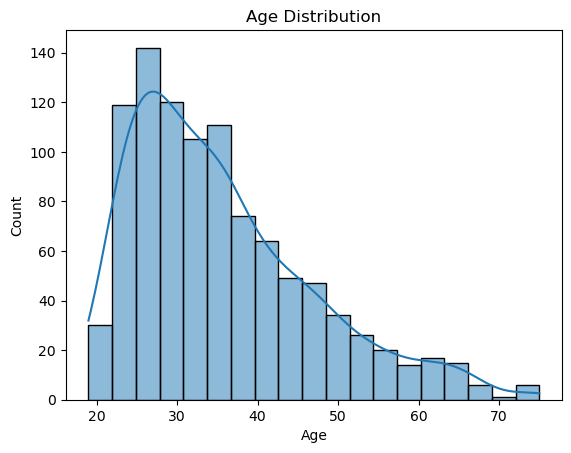

In [88]:
# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

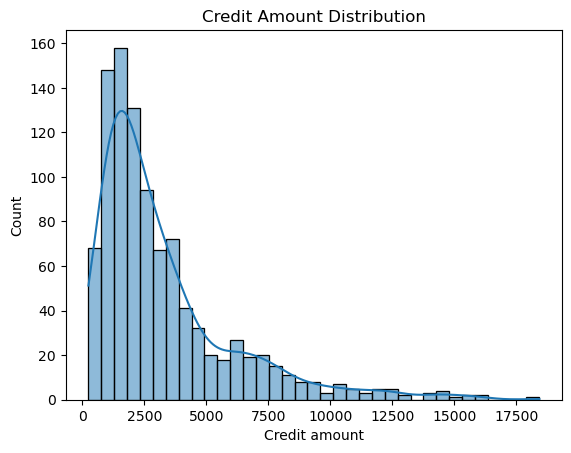

In [89]:
# Credit amount distribution
sns.histplot(df['Credit amount'], kde=True)
plt.title('Credit Amount Distribution')
plt.show()

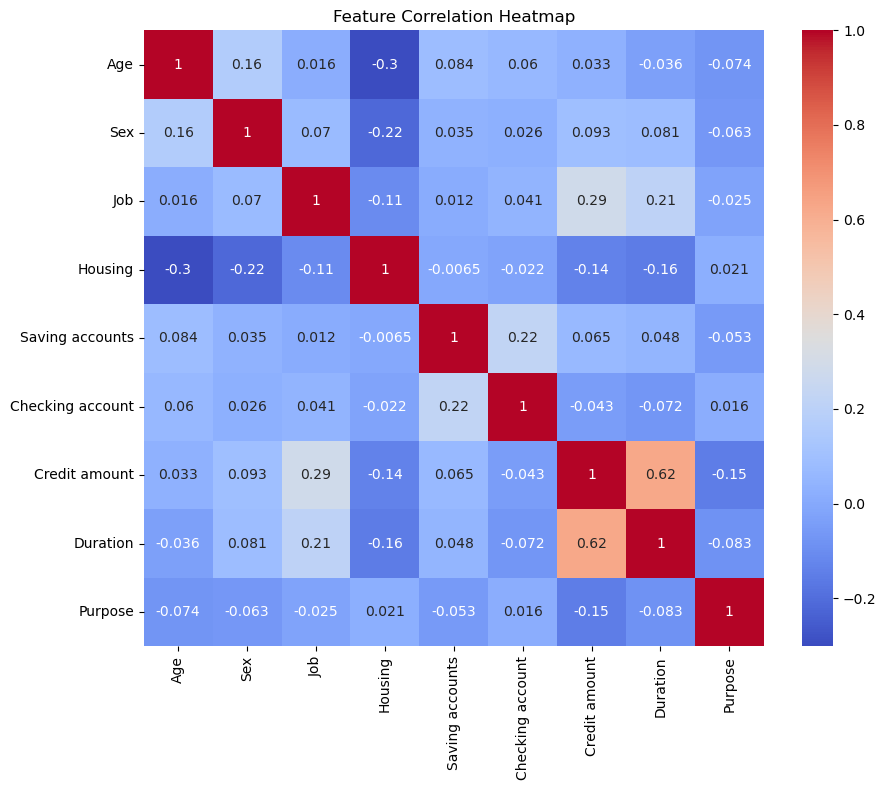

In [90]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Train/test split

In [91]:
# Define features and target
X = df.drop(columns=['Credit amount'])
y = df['Credit amount'] > df['Credit amount'].median()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=Seed)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define Model

In [92]:
modelRF = RandomForestClassifier()

# RandomSearch for best param

In [93]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
#     'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#     'min_samples_split': [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
#     'min_samples_leaf': [1, 2, 4, 8, 16, 32, 64, 128, 256],
#     'bootstrap': [True, False],
#     'max_features': ['sqrt', 'log2', None],
#     'criterion': ['gini', 'entropy'],
#     'class_weight': [None, 'balanced']
# }


# # RandomizedSearchCV
# RandomForestModel = RandomizedSearchCV(
#     estimator=modelRF,
#     param_distributions=param_grid,
#     n_iter=500,
#     cv=5,
#     scoring='accuracy',
#     random_state=Seed,
#     n_jobs=-1
# )

# Fit Model

In [94]:
# # Fit the model
# RandomForestModel.fit(X_train, y_train)  # Dodaj ten krok

# # Print the best parameters and best accuracy
# print("Best Parameters:", RandomForestModel.best_params_)
# print("Best Accuracy:", RandomForestModel.best_score_)

In [95]:
# Define the model with the best parameters (overwrite RandomForestModel)
RandomForestModel = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    min_samples_leaf=32,
    max_features='sqrt',
    max_depth=10,
    criterion='entropy',
    class_weight=None,
    bootstrap=True,
    random_state=Seed
)

# Fit the model with the best parameters
RandomForestModel.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=32,
                       min_samples_split=10, n_estimators=300, random_state=12)

# Evaluete

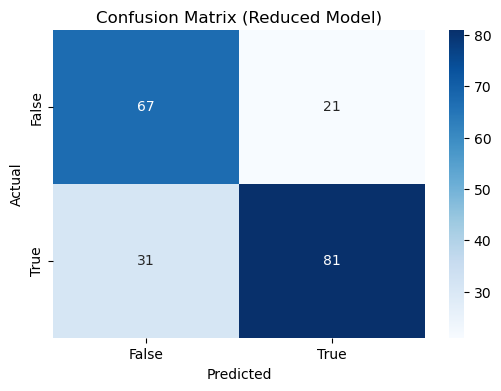

Accuracy: 0.74

Classification Report:
              precision    recall  f1-score   support

       False       0.68      0.76      0.72        88
        True       0.79      0.72      0.76       112

    accuracy                           0.74       200
   macro avg       0.74      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



In [96]:
# Evaluate the model
y_pred = RandomForestModel.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Reduced Model)")
plt.show()

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

# Future Importance

In [97]:
# # Get best estimator
# best_rf = RandomForestModel.best_estimator_

In [98]:
best_rf = RandomForestModel

Feature Importances:
            Feature  Importance
6          Duration    0.681115
2               Job    0.116628
0               Age    0.060344
7           Purpose    0.055786
3           Housing    0.025144
1               Sex    0.023290
4   Saving accounts    0.020223
5  Checking account    0.017470


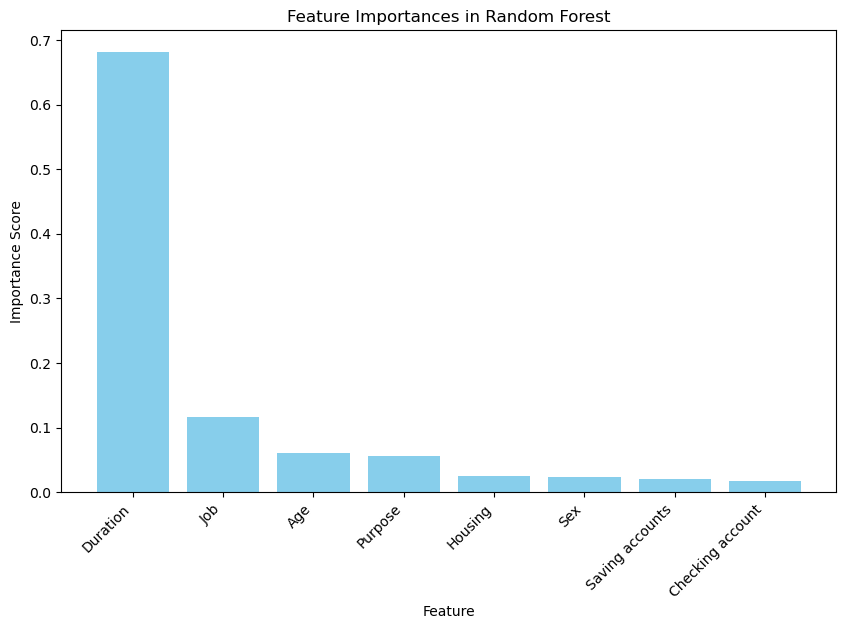

In [99]:
# Calculate feature importance
importances = best_rf.feature_importances_
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importances
print("Feature Importances:")
print(feature_importances)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.title('Feature Importances in Random Forest')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.show()

In [100]:
# Define threshold
threshold = 0.05

# Select important features
important_features = feature_importances[feature_importances['Importance'] > threshold]['Feature']

print(f"Cechy istotne (powyżej progu {threshold}):")
print(important_features)

Cechy istotne (powyżej progu 0.05):
6    Duration
2         Job
0         Age
7     Purpose
Name: Feature, dtype: object


# Train model with reduced features

In [101]:
# Convert X_train and X_test back to DataFrame
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Reduce features
X_train_reduced = X_train[important_features]
X_test_reduced = X_test[important_features]

# Retrain model
best_rf.fit(X_train_reduced, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=32,
                       min_samples_split=10, n_estimators=300, random_state=12)

Reduced Model Accuracy: 0.75

Classification Report (Reduced Model):
              precision    recall  f1-score   support

       False       0.69      0.77      0.73        88
        True       0.80      0.73      0.77       112

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200



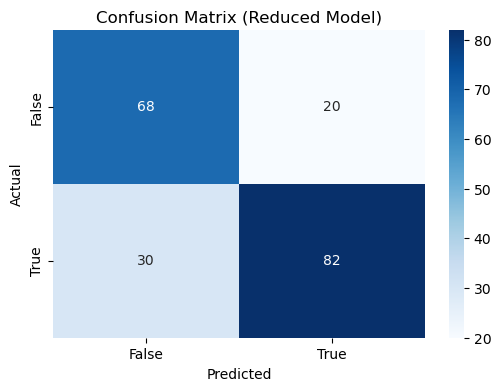

In [102]:
# Evaluate the reduced model
y_pred_reduced = best_rf.predict(X_test_reduced)

# Calculate accuracy
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
print("Reduced Model Accuracy:", accuracy_reduced)

# Confusion Matrix
cm_reduced = confusion_matrix(y_test, y_pred_reduced)

# Classification Report
report_reduced = classification_report(y_test, y_pred_reduced)
print("\nClassification Report (Reduced Model):")
print(report_reduced)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_reduced, annot=True, fmt="d", cmap="Blues", xticklabels=["False", "True"], yticklabels=["False", "True"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Reduced Model)")
plt.show()

# Key Observations and Conclusions:

## Impact of Feature Reduction:
- The accuracy slightly improved after the feature reduction, indicating that reducing features might have helped to focus on more relevant predictors while ignoring noise.

## Confusion Matrix Insights:
- There is still a slight imbalance in correctly identifying False and True categories, with a minor improvement in prediction accuracy after feature importance selection.

## Feature Importance Impact:
- Although the accuracy and classification report show improvement, the gains are marginal, suggesting that feature importance helped streamline the model but did not dramatically change the predictive power.
